In [39]:
from sklearn import preprocessing as pp
from sklearn import feature_selection as fs
from sklearn import decomposition as dr
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
import pickle
import seaborn as sns

def give_unique_react(df: pd.DataFrame):
    df_iso = df[["Reactant SMILES", "Olefin Type"]]
    return df_iso.drop_duplicates()

def create_smi_mol_map(react_df: pd.DataFrame):
    id = react_df.index
    smiles_str = react_df["Reactant SMILES"].values

    mol_dict = dict()

    for i, smiles in zip(id, smiles_str):
        mol = Chem.MolFromSmiles(smiles)
        mol.SetProp("_Name", i)
        mol_dict[smiles] = mol

    return mol_dict

def visualize_score_plots(
    alk_type_dict: dict,
    fs_pipe,
    dr_method,
    comp_name,
    dim=2,
    name="test",
    plot=False,
):

    color_dict = {
        "Mono": "tab:blue",
        "Gem": "tab:orange",
        "Cis": "tab:red",
        "Trans": "tab:green",
        "TriQ2": "tab:purple",
        "TriQ3": "tab:purple",
        "TriQ4": "tab:purple",
        "Tetra": "tab:brown",
    }
    marker_dict = {
        "Mono": "o",
        "Gem": "^",
        "Cis": "*",
        "Trans": "s",
        "TriQ2": "^",
        "TriQ3": ">",
        "TriQ4": "<",
        "Tetra": "P",
    }
    alpha_dict = {
        "Mono": 1,
        "Gem": 1,
        "Cis": 1,
        "Trans": 1,
        "TriQ2": 1,
        "TriQ3": 1,
        "TriQ4": 1,
        "Tetra": 1,
    }

    label_ser = np.array(list(alk_type_dict.values()))

    mono_ser = np.where(label_ser == "Mono")[0]
    gem_di_ser = np.where(label_ser == "Gem")[0]
    cis_di_ser = np.where(label_ser == "Cis")[0]
    trans_di_ser = np.where(label_ser == "Trans")[0]
    triq2_ser = np.where(label_ser == "TriQ2")[0]
    triq3_ser = np.where(label_ser == "TriQ3")[0]
    triq4_ser = np.where(label_ser == "TriQ4")[0]
    tetra_ser = np.where(label_ser == "Tetra")[0]

    all_alkene_types = ["Mono", "Gem", "Cis", "Trans", "TriQ2", "TriQ3", "TriQ4", "Tetra"]
    all_alkene_dict = dict(
        zip(
            all_alkene_types,
            [mono_ser, gem_di_ser, cis_di_ser, trans_di_ser, triq2_ser, triq3_ser, triq4_ser, tetra_ser],
        )
    )
    legend_handles = list()

    fig = plt.figure()
    ax = fig.add_subplot(111)
 
    match dr_method:
        case dr.PCA:
            # print('doing PCA')
            dr_test = dr_method(n_components=dim, random_state=42).fit(fs_pipe)
            print(
                f"{(ev := round(np.sum(dr_test.explained_variance_ratio_),2))} is the explained variance ratio of the {dim}D space"
            )
            dr_pipe = dr_method(n_components=dim, random_state=42).fit_transform(
                fs_pipe
            )
        case _:
            raise ValueError(f"Unknown Method: {dr_method}")

    plt.xlabel(f"{comp_name} 1", weight='bold',fontsize=20)
    plt.ylabel(f"{comp_name} 2", weight='bold', fontsize=20)

    plt.title(f"{comp_name} Visualization {dim}D {name}",fontsize=24)
    # print(dr_pipe)
    for alk_type, idx in all_alkene_dict.items():

        scatter = ax.scatter(
            dr_pipe[idx, 0],
            dr_pipe[idx, 1],
            s=50,
            alpha=alpha_dict[alk_type],
            c=color_dict[alk_type],
            marker=marker_dict[alk_type],
        )
        scatter.set_label(alk_type)
        legend_handles.append(scatter)

    plt.legend()
    
    sns.move_legend(ax, "upper right", bbox_to_anchor=(1.25, 1.03))
    plt.tight_layout()

    if plot:
        plt.show()
    plt.close()

def visualize_ad_ex_score(
    type_dict: dict, 
    fs_pipe, 
    dr_method, 
    comp_name, 
    dim=2, 
    name="test",
    plot=False
):

    color_dict = {
        "SAD Database": "tab:blue", 
        "External Dataset": "tab:grey",}
    marker_dict = {
        "SAD Database": "o",
        "External Dataset": "^",
    }
    alpha_dict = {
        "SAD Database": 0.4,
        "External Dataset": 0.2,
    }

    label_ser = np.array(list(type_dict.values()))

    in_database = np.where(label_ser == "SAD Database")[0]
    external = np.where(label_ser == "External Dataset")[0]

    all_types = ["SAD Database", "External Dataset"]
    all_type_dict = dict(zip(all_types, [in_database, external]))

    legend_handles = list()

    fig = plt.figure()
    ax = fig.add_subplot(111)

    match dr_method:
        case dr.PCA:
            # print('doing PCA')
            dr_test = dr_method(n_components=dim, random_state=42).fit(fs_pipe)
            print(
                f"{(ev := round(np.sum(dr_test.explained_variance_ratio_),2))} is the explained variance ratio of the {dim}D space"
            )
            dr_pipe = dr_method(n_components=dim, random_state=42).fit_transform(
                fs_pipe
            )
        case _:
            raise ValueError(f"Unknown Method: {dr_method}")
        
    plt.xlabel(f"{comp_name} 1", weight='bold',fontsize=20)
    plt.ylabel(f"{comp_name} 2", weight='bold', fontsize=20)

    plt.title(f"{comp_name} Visualization {dim}D {name}",fontsize=20)

    for alk_type, idx in all_type_dict.items():
        scatter = ax.scatter(
            dr_pipe[idx, 0],
            dr_pipe[idx, 1],
            # s=5,
            alpha=alpha_dict[alk_type],
            c=color_dict[alk_type],
            marker=marker_dict[alk_type],
        )
        scatter.set_label(alk_type)
        legend_handles.append(scatter)
        if dim == 3:
            scatter = ax.scatter(
                dr_pipe[idx, 0],
                dr_pipe[idx, 1],
                dr_pipe[idx, 2],
                s=5,
                alpha=alpha_dict[alk_type],
                c=color_dict[alk_type],
                marker=marker_dict[alk_type],
            )
            scatter.set_label(alk_type)
            legend_handles.append(scatter)

    lgd = ax.legend(handles=legend_handles)
    
    plt.tight_layout()

    if plot:
        plt.show()
    plt.close()

def visualize_ad_ex_ev_score(
    type_dict: dict, 
    fs_pipe, 
    dr_method, 
    comp_name, 
    dim=2, 
    name="test",
    plot=False
):

    color_dict = {
        "SAD Database": "tab:blue", 
        "External Dataset": "tab:grey",
        "Experimental Validation": "tab:red"}
    marker_dict = {
        "SAD Database": "o",
        "External Dataset": "^",
        "Experimental Validation": "*",
    }
    alpha_dict = {
        "SAD Database": 0.4,
        "External Dataset": 0.2,
        "Experimental Validation": 1
    }

    label_ser = np.array(list(type_dict.values()))

    in_database = np.where(label_ser == "SAD Database")[0]
    external = np.where(label_ser == "External Dataset")[0]
    experimental = np.where(label_ser == "Experimental Validation")[0]

    all_types = ["SAD Database", "External Dataset", "Experimental Validation"]
    all_type_dict = dict(zip(all_types, [in_database, external, experimental]))

    legend_handles = list()

    fig = plt.figure()
    ax = fig.add_subplot(111)

    match dr_method:
        case dr.PCA:
            # print('doing PCA')
            dr_test = dr_method(n_components=dim, random_state=42).fit(fs_pipe)
            print(
                f"{(ev := round(np.sum(dr_test.explained_variance_ratio_),2))} is the explained variance ratio of the {dim}D space"
            )
            dr_pipe = dr_method(n_components=dim, random_state=42).fit_transform(
                fs_pipe
            )
        case _:
            raise ValueError(f"Unknown Method: {dr_method}")
        
    plt.xlabel(f"{comp_name} 1", weight='bold',fontsize=20)
    plt.ylabel(f"{comp_name} 2", weight='bold', fontsize=20)

    plt.title(f"{comp_name} Visualization {dim}D {name}",fontsize=20)

    for alk_type, idx in all_type_dict.items():
        scatter = ax.scatter(
            dr_pipe[idx, 0],
            dr_pipe[idx, 1],
            # s=5,
            alpha=alpha_dict[alk_type],
            c=color_dict[alk_type],
            marker=marker_dict[alk_type],
        )
        scatter.set_label(alk_type)
        legend_handles.append(scatter)
        if dim == 3:
            scatter = ax.scatter(
                dr_pipe[idx, 0],
                dr_pipe[idx, 1],
                dr_pipe[idx, 2],
                s=5,
                alpha=alpha_dict[alk_type],
                c=color_dict[alk_type],
                marker=marker_dict[alk_type],
            )
            scatter.set_label(alk_type)
            legend_handles.append(scatter)

    lgd = ax.legend(handles=legend_handles)
    
    plt.tight_layout()

    if plot:
        plt.show()
    plt.close()

sns.set_theme(style="ticks", font='Arial')

Currently evaluating PCA projections for MaxVol
SAD Database
0.37 is the explained variance ratio of the 2D space


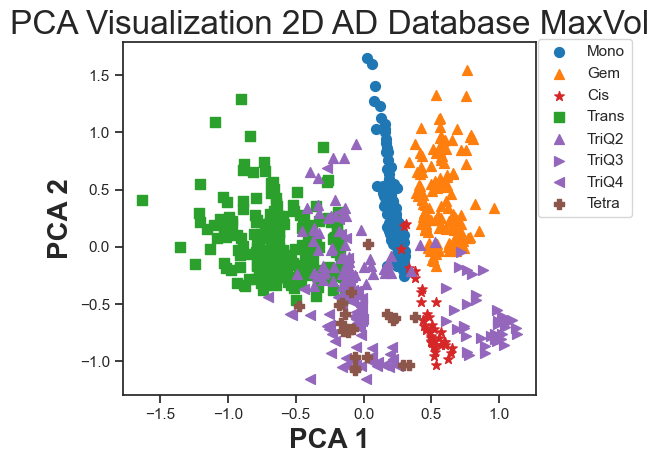

External
0.41 is the explained variance ratio of the 2D space


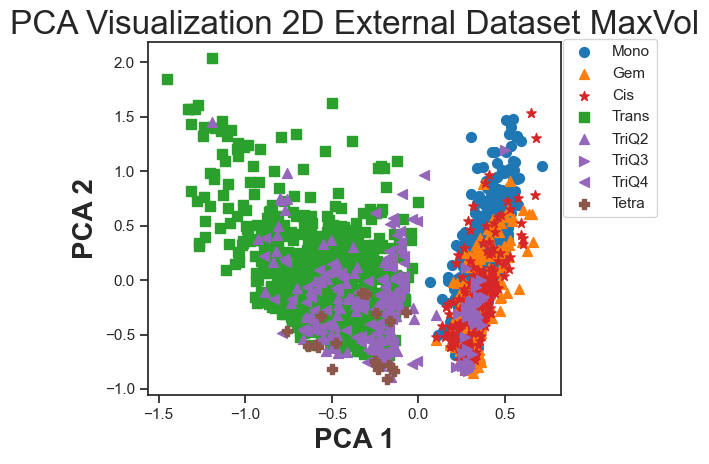

SAD/External
0.4 is the explained variance ratio of the 2D space


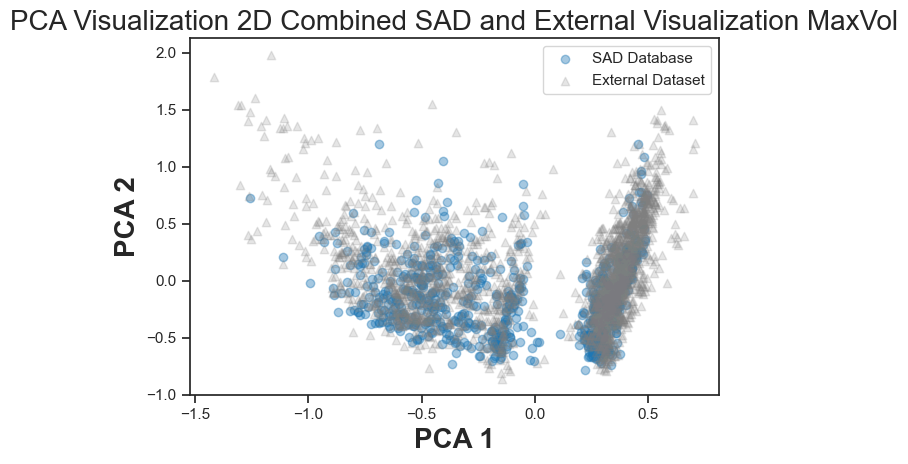

SAD/Ex/EV
0.4 is the explained variance ratio of the 2D space


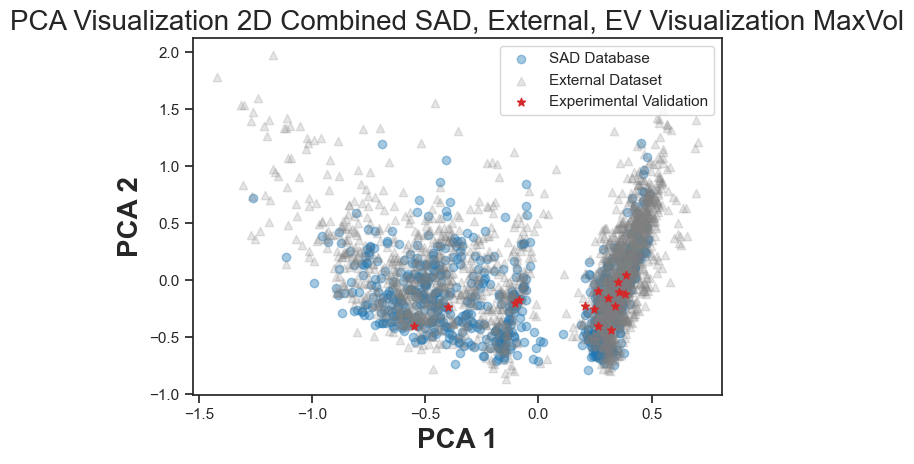

Currently evaluating PCA projections for BFSVol
SAD Database
0.39 is the explained variance ratio of the 2D space


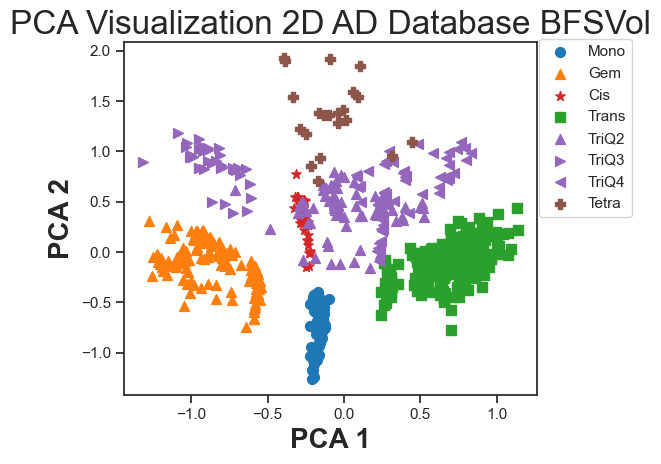

External
0.42 is the explained variance ratio of the 2D space


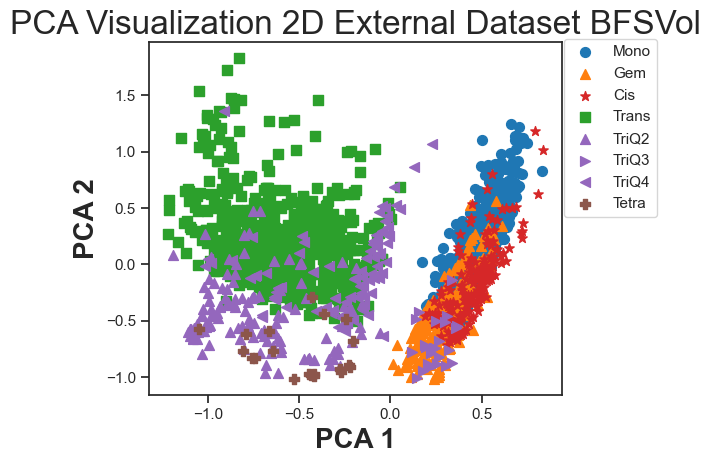

SAD/External
0.42 is the explained variance ratio of the 2D space


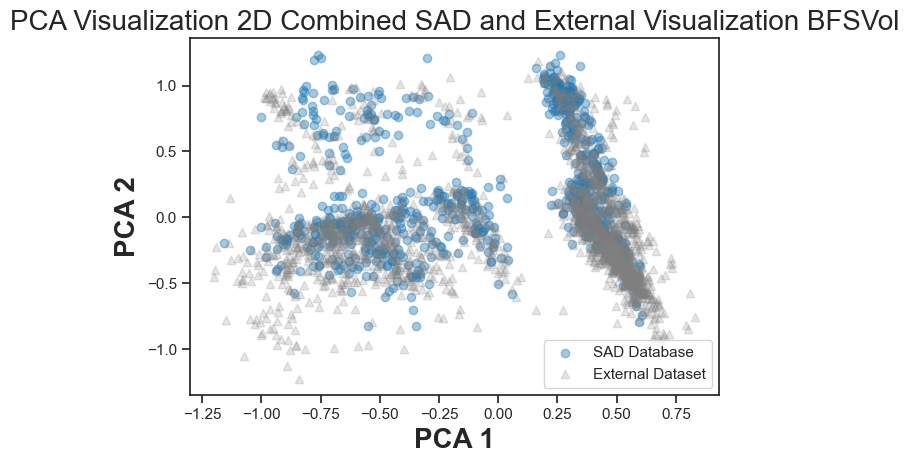

SAD/Ex/EV
0.42 is the explained variance ratio of the 2D space


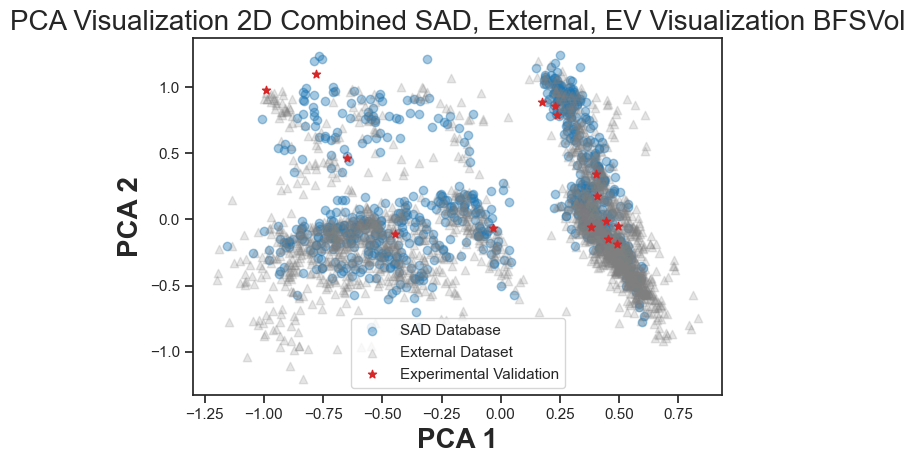

In [40]:
db_df = pd.read_csv("SAD_Database.csv",index_col=0)

alkene_iso = give_unique_react(db_df)
db_smi_mol = create_smi_mol_map(alkene_iso)

vols = ['MaxVol', 'BFSVol']

dr_method = dr.PCA
comp_name = "PCA"

dim = 2

for vol_type in vols:
    print(f'Currently evaluating PCA projections for {vol_type}')
    # These are mapping overlapping names from the database to the external dataset
    with open(f'DB_EX_Name_{vol_type}_Map.pkl','rb') as f:
        db_ex_name_map = pickle.load(f)

    # These are mapping overlapping names from the experimental validation to the external dataset
    with open(f'EV_EX_Name_{vol_type}_Map.pkl', 'rb') as f:
        ev_ex_name_map = pickle.load(f)

    #Experimental Validation Descriptor Matrix
    ev_df_w_type = pd.read_csv(f'Experimental_Validation_Full_Alkene_Desc_{vol_type}.csv',index_col=0)

    #External Dataset Descriptor Matrix
    ex_df_w_type = pd.read_csv(f"External_Full_Alkene_Desc_{vol_type}.csv", index_col=0)
    
    #SAD Database Descriptor Matrix
    desc_df_w_type = pd.read_csv(f"Database_Full_Alkene_Desc_{vol_type}.csv", index_col=0)

    #Corrects alkene type to match the volume alignment
    for x in db_df.index:
        db_df.loc[x, ['Olefin Type']] = desc_df_w_type.loc[x,'Alkene Type']

    db_alk_type_dict = desc_df_w_type['Alkene Type'].to_dict()

    # Removes alkene type
    db_desc_df = desc_df_w_type.loc[:, desc_df_w_type.columns != 'Alkene Type']

    pipe = Pipeline(
        steps=[("scaler", pp.MinMaxScaler()), ("vt", fs.VarianceThreshold(threshold=0))]
    )
    ad_db_fs_pipe = pipe.fit_transform(db_desc_df)
    print('SAD Database')

    #Visualization of the SAD Database
    visualize_score_plots(
    db_alk_type_dict,
    ad_db_fs_pipe,
    dr_method=dr_method,
    comp_name=comp_name,
    dim=dim,
    name=f'AD Database {vol_type}',
    plot=True
    )

    ####
    '''
    This focuses entirely on the External Dataset (Including overlap with DB and EV)
    '''
    ####
    ex_alk_type_dict = ex_df_w_type['Alkene Type'].to_dict()

    # Removes alkene type
    ex_desc_df = ex_df_w_type.loc[:, ex_df_w_type.columns != 'Alkene Type']

    pipe = Pipeline(
        steps=[("scaler", pp.MinMaxScaler()), ("vt", fs.VarianceThreshold(threshold=0))]
    )

    ex_db_fs_pipe = pipe.fit_transform(ex_desc_df)
    print('External')
    visualize_score_plots(
    ex_alk_type_dict,
    ex_db_fs_pipe,
    dr_method=dr_method,
    comp_name=comp_name,
    dim=dim,
    name=f'External Dataset {vol_type}',
    plot=True
    )

    ####
    '''
    This focuses on the overlap of the DB and External Dataset, including overlap with EV, but removing redunant
    overlap with the DB to prevent overrepresentation. 343 alkenes are removed from the External Dataset for 
    already being present in the SAD Database.
    '''
    ####

    redundant_ex = ex_desc_df.index.isin(list(db_ex_name_map.values()))

    fix_ex_desc_df = ex_desc_df[~redundant_ex]

    merge_db_ex = pd.concat([db_desc_df, fix_ex_desc_df])

    pipe = Pipeline(
        steps=[("scaler", pp.MinMaxScaler()), ("vt", fs.VarianceThreshold(threshold=0))]
    )

    merge_db_fs_pipe = pipe.fit_transform(merge_db_ex)

    in_db = dict()
    for name in merge_db_ex.index:
        if 'react' in name:
            in_db[name] = 'SAD Database'
        else:
            in_db[name] = 'External Dataset'

    print('SAD/External')
    visualize_ad_ex_score(
        in_db,
        merge_db_fs_pipe,
        dr_method=dr_method,
        comp_name=comp_name,
        dim=dim,
        name=f"Combined SAD and External Visualization {vol_type}",
        plot=True
    )

    ####
    '''
    This focuses on the overlap of the DB and External Dataset and Experimental Validation, removing redunant
    overlap with the DB and External Dataset to prevent overrepresentation. 343 alkenes are removed from the External Dataset for 
    already being present in the SAD Database and an additional 5 alkenes are removed from the External Dataset for
    already being present in the Experimental Validation.
    '''
    ####

    redundant_sad_ex = ex_desc_df.index.isin(list(db_ex_name_map.values()))

    ad_fix_ex_desc_df = ex_desc_df[~redundant_ex]    

    redundant_ev_ex = ad_fix_ex_desc_df.index.isin(list(ev_ex_name_map.values()))

    full_fix_ex_desc_df = ad_fix_ex_desc_df[~redundant_ev_ex]

    # Removes alkene type
    ev_desc_df = ev_df_w_type.loc[:, ev_df_w_type.columns != 'Alkene Type']

    merge_db_ex_ev = pd.concat([db_desc_df, full_fix_ex_desc_df, ev_desc_df])

    pipe = Pipeline(
        steps=[("scaler", pp.MinMaxScaler()), ("vt", fs.VarianceThreshold(threshold=0))]
    )

    merge_db_fs_pipe = pipe.fit_transform(merge_db_ex_ev)

    in_db = dict()


    for name in merge_db_ex_ev.index:
        if 'react' in name:
            in_db[name] = 'SAD Database'
        elif 'Ex' in name:
            in_db[name] = 'Experimental Validation'
        else:
            in_db[name] = 'External Dataset'
            
    print('SAD/Ex/EV')
    visualize_ad_ex_ev_score(
        in_db,
        merge_db_fs_pipe,
        dr_method=dr_method,
        comp_name=comp_name,
        dim=dim,
        name=f"Combined SAD, External, EV Visualization {vol_type}",
        plot=True
    )
